In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from Bio.PDB import PDBParser, PPBuilder
import py3Dmol, pathlib
import pcmap
import math
from tqdm import trange

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch #https://github.com/facebookresearch/esm
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 3 on the node
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-32GB


### Loading .pdb files

In [2]:
interaction_df = pd.read_csv("../data/meta_analysis/source_data.csv")
interaction_df = interaction_df[(interaction_df["A_seq"].notna())& (interaction_df["B_seq"].notna())].reset_index(drop=True)
interaction_df = interaction_df[interaction_df["target_chains"] == "[\"B\"]"]
interaction_df = interaction_df[interaction_df["B_seq"].notna()].reset_index(drop=True)
cols_remain = ["binder_id", "target_id", "binder_chain", "target_chains", "binder", "A_seq", "B_seq"]
interaction_df = interaction_df[cols_remain]
# interaction_df = interaction_df.drop(columns=["binder_chain", "target_chains"])

# Adding new target id
dfu = interaction_df.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}

for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1

interaction_df['target_id_mod'] = interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
cnt = interaction_df.groupby('target_id_mod').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id_mod'].astype(str) + '_' + cnt.astype(str)
interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod,target_binder_ID
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


In [3]:
interaction_df[interaction_df["target_binder_ID"] == "EGFR_2_279"]

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod,target_binder_ID
3160,jakublala_full_dibinder_45aa_pdb,EGFR,A,"[""B""]",False,DGYPESNIMTRNPEENIDQFLEKQLYKINLFAREDQQMQQYDRDP,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_279


### Loading ESM2 model

In [4]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
model.eval().to("cuda")
batch_converter = alphabet.get_batch_converter()

model

Using cache found in /work3/s232958/torch/hub/facebookresearch_esm_main


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

### Loading meta-analysis sequences and pdb files

In [5]:
data = []
pdbs_Dict = {}
for row in interaction_df.iloc():
    binder_id = row.target_binder_ID
    pdb_name = f"{row.binder_id}.pdb"
    pdb_path = os.path.join("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/input_pdbs/input_pdbs/", pdb_name)
    seq = row.A_seq
    pdbs_Dict[binder_id] = pdb_path
    data.append((binder_id, seq))

batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)  # tensor([L_plus_special])

print(len(batch_labels), "e.g.:", batch_labels[1]) # binder ids
print(len(batch_strs), "e.g.:", batch_strs[1]) # sequences
print(batch_tokens.shape, "e.g.:", batch_tokens[1]) # shape (batch_size, max_len_in_batch)
# all the sequences in the batch are padded to be the same in length
assert int(batch_lens[1]) == (batch_tokens[1] != 1).sum().item()
# counts all non-PAD tokens, i.e. it includes BOS/CLS and EOS too. So each batch_lens[i] equals:
# true_residue_length + 2   # (+1 for BOS/CLS at pos 0, +1 for EOS at the end)

3532 e.g.: FGFR2_1
3532 e.g.: SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEAKKLVRSLQEYLESILS
torch.Size([3532, 252]) e.g.: tensor([ 0,  8,  9, 16, 13,  9, 11, 20, 21, 10, 12,  7, 10,  8,  7, 12, 16, 21,
         5, 19, 15, 21, 17, 13,  9, 20,  5,  9, 19, 18,  5, 16, 17,  5,  5,  9,
        12, 19, 15,  9, 16, 17, 15,  8,  9,  9,  5, 15, 15,  4,  7, 10,  8,  4,
        16,  9, 19,  4,  9,  8, 12,  4,  8,  2,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  

In [6]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 2.425342GB
torch.cuda.memory_reserved: 2.445312GB
torch.cuda.max_memory_reserved: 2.445312GB


### Parsing one sequence/pdb at the time; creating dict() binder_id : contact map `all_contacts`

Batches:   0%|                             | 0/3532 [00:00<?, ?it/s]

torch.Size([250, 250])


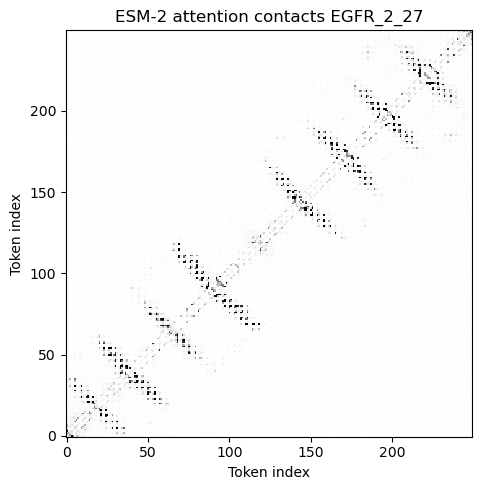

Batches:  14%|██▋                | 497/3532 [00:16<01:27, 34.66it/s]

torch.Size([80, 80])


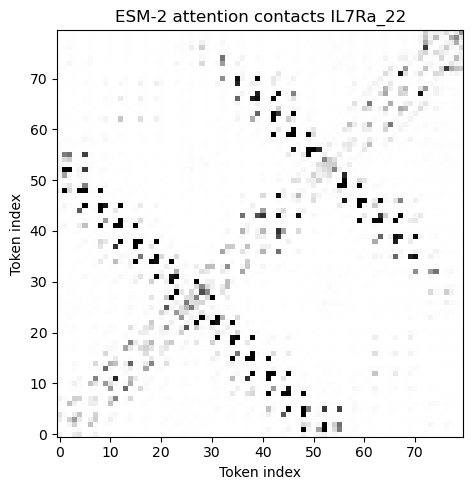

Batches:  28%|█████▎             | 997/3532 [00:30<01:07, 37.28it/s]

torch.Size([65, 65])


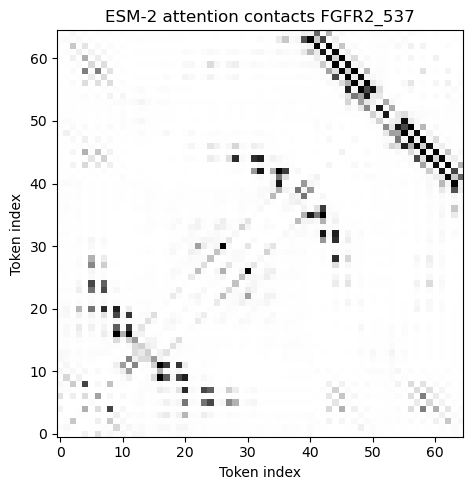

Batches:  42%|███████▋          | 1497/3532 [00:43<00:54, 37.20it/s]

torch.Size([65, 65])


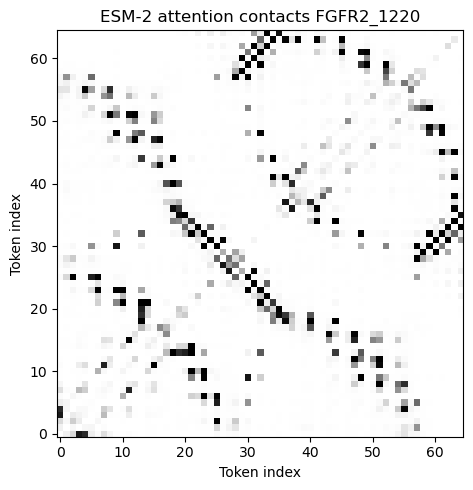

Batches:  57%|██████████▏       | 1997/3532 [00:57<00:41, 37.15it/s]

torch.Size([65, 65])


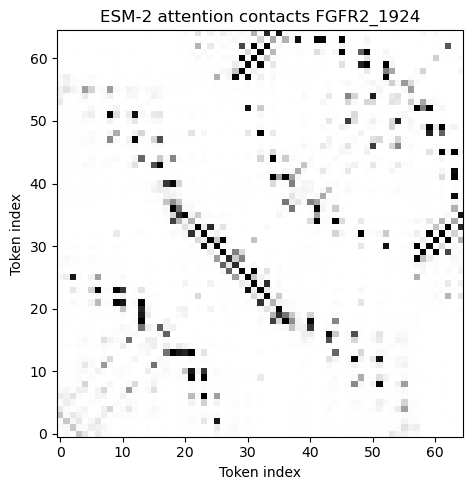

Batches:  71%|████████████▋     | 2497/3532 [01:11<00:27, 37.01it/s]

torch.Size([63, 63])


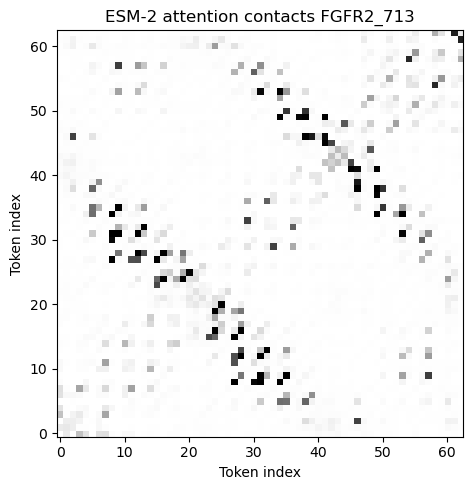

Batches:  85%|███████████████▎  | 2997/3532 [01:24<00:14, 37.67it/s]

torch.Size([61, 61])


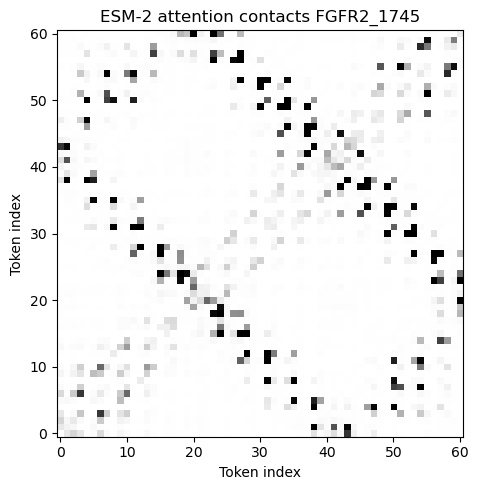

Batches:  99%|█████████████████▊| 3497/3532 [01:38<00:00, 35.89it/s]

torch.Size([40, 40])


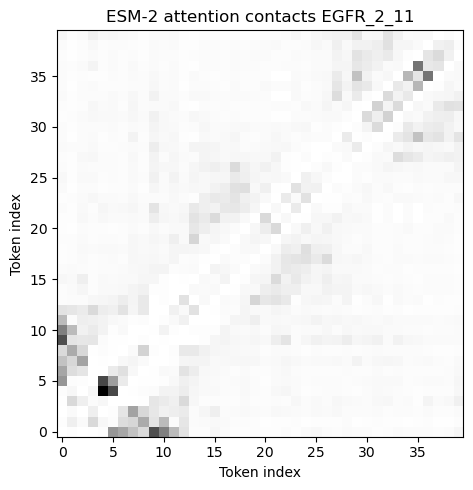

Batches: 100%|██████████████████| 3532/3532 [01:40<00:00, 35.29it/s]


In [7]:
# sort by sequence length to reduce padding waste
data_sorted = sorted(data, key=lambda x: len(x[1]), reverse=True)

batch_size = 1
n = len(data_sorted)

all_contacts = {}
L = model.num_layers

for i, start in enumerate(trange(0, n, batch_size, desc="Batches")):
    batch = data_sorted[start:start+batch_size]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch)
    batch_tokens = batch_tokens.to("cuda")
    lens = (batch_tokens != alphabet.padding_idx).sum(dim=1).tolist()
    
    with torch.no_grad():
        out = model(batch_tokens, repr_layers=[L], return_contacts=True)
    contacts = out["contacts"][0].float().cpu()  # (B, T, C)
    # tokens_len = int(batch_lens)
    # contacts = contacts[:tokens_len, :tokens_len]
    
    idx = data_sorted[i][0]
    all_contacts[idx] = contacts

    # image check
    if i % 500 == 0:
        print(contacts.shape)
        plt.figure(figsize=(5,5))
        plt.imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
        plt.title(f"ESM-2 attention contacts {data_sorted[i][0]}")
        plt.xlabel("Token index")
        plt.ylabel("Token index")
        plt.tight_layout()
        plt.show()
    else:
        pass

    del out, contacts, batch_tokens
    torch.cuda.empty_cache()

### P@L

`P@L` means “precision at L” and it’s a standard way to score contact/interaction maps in proteins.
- Compute a score for each pair (i,j) with ∣i−j∣ above a minimum sequence separation (often ≥ 12 or ≥ 24 to count only **“long-range”**).
- Sort all pairs by predicted score (descending).
- Take the top L pairs.
- P@L = (# true contacts in top L) / L.

Differeces between the cutoffs:
- `P@L`: precision on the top L pairs (L = sequence length). This is the **most common** headline metric.
- `P@L/5`: precision using only the top L/5 pairs. **Very strict**—focuses on your very highest-confidence predictions.
- `P@L/2`: precision on the top L/2 pairs. A bit **broader than L/5**.
- `P@2L`: precision on the top 2L pairs. Tests performance **deeper into the ranked list**.

#### True contacts:
 - cutoff Cβ–Cβ < 8 Å,
 - minimal seqeunce separation >= 6/12/24 Å)

In [27]:
### pdbs_Dict dict() - binder_id : path_to_pdb_file
### all_constacts dict() - binder_id : contacts

In [28]:
print(data[0])
print(len(data[0][1]))
idx = data[0][0]
print(all_contacts[idx].shape)

('VirB8_1', 'LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK')
40
torch.Size([40, 40])


In [101]:
short_range, medium_range, long_range = 6, 12, 24 # 6 might be enough as mini-binders are rather small

def true_contacts_ca(pdb_path, chain_id=None, cutoff=8.0, min_seq_sep=6):

    """
    True contacts:
    - Cα–Cα < cutoff=8.0
    - distance between i and j >= min_seq_sep
    """
    
    struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
    # collect Cα coords
    coords = [res["CA"].coord for res in struct[0]["A"] if res.id[0] == " " and "CA" in res]
    X = np.asarray(coords) # [len, 3 coordinates of Cα]
    N = len(X) # length of the sequence
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N] # Cα–Cα pairwise distance matrix
    
    T = (D <= cutoff) # True where the distance is smaller than cutoff
    # remove self and short-range    
    i,j = np.triu_indices(N, k=1)
    short = (np.abs(i-j) < min_seq_sep)
    T[i[short], j[short]] = False
    T[j[short], i[short]] = False

    # plt.figure(figsize=(5,5))
    # plt.imshow(-D, origin="lower", interpolation="nearest", cmap="binary")
    # plt.title(f"Contact map (ground truth))")
    # plt.xlabel("Residue index (sorted by PDB resID)")
    # plt.ylabel("Residue index (sorted by PDB resID)")
    # plt.tight_layout()
    # plt.show()
    
    return D, T
    # D - original distances matrix
    # T - True were distance is lower than 8

In [92]:
def sorting_interactions(D_pred, min_seq_sep=6):

    """
    This function only for the contact computed from the heads/contact maps:
    - sort all the valid contacts by their values
    - separation between residues in the seqeunce muct be not < 24 A 
    """
    
    interactions = {}
    for i, row in enumerate(D_pred):
        for j, col in enumerate(row):
            if j <= i:
                continue  # skip diagonal and opposite (keep only upper triangle)
            if abs(i - j) < min_seq_sep:
                continue  # enforce long-range only
            key = f"{i},{j}"
            # robust float extraction for torch / numpy
            val = float(D_pred[i, j].item() if hasattr(D_pred[i, j], "item") else D_pred[i, j])
            interactions[key] = val
    
    sorted_interactions = sorted(interactions.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_interactions

def precision_at_L(sorted_interactions, T_ground_bool, L):
    top = sorted_interactions[:L]
    if not top:
        return float('nan')
    hits = 0
    for key, _ in top:
        i, j = map(int, key.split(','))
        if bool(T_ground_bool[i, j]):
            hits += 1

    return round(hits / len(top), 3)

In [94]:
i = random.randint(0, len(data))
print("Entry:")
print(data[i], "\n")
batch_labels, batch_strs, batch_tokens = batch_converter([data[i]]) # batch_converter adds special token PAD to make allt he sequences in the batch equal size
batch_tokens = batch_tokens.to("cuda")

lens_tokens = (batch_tokens != alphabet.padding_idx).sum(1) # claculated not padded token, include CLS/EOS (since only one sequence parsed, no padding was added)
lens_res = (batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (batch_tokens != alphabet.eos_idx) # True for true residues, False for CLS/EOS
lens = int(lens_res.sum(1)[0]) # residues only

with torch.no_grad():
    out = model(batch_tokens, repr_layers=[L], return_contacts=True)
    
    contacts = out["contacts"][0].float().cpu()  # (B, T, C)
    D_pred = contacts[:lens, :lens]
    attentions = out["attentions"][0, -1, :, :, :].float().cpu() # [H, T', T']

    binder_id = data[i][0]
    seq = data[i][1]
    N = len(seq)
    print(f"Len sequence: {N}")
    pdb_path = pdbs_Dict[binder_id]

    __, T_ground_bool = true_contacts_ca(pdb_path)
    
    sorted_interactions = sorting_interactions(D_pred)

    # print(f"Sorted contacts (top 20 out of {len(sorted_interactions)}):")
    # for i in sorted_interactions[:20]:
    #     print(i)
    # print()
    
    hits = 0
    top = sorted_interactions[:N]
    for idx, (key, _) in enumerate(top):
        i, j = map(int, key.split(','))
        if bool(T_ground_bool[i, j]):
            hits += 1
        print(sorted_interactions[:N][idx], "\t", bool(T_ground_bool[i, j]))
    print(round(hits / len(top), 3))

Entry:
('FGFR2_1085', 'SEEEHIEKSVKRAAEVAGVESVSVRVSNGTIEVHLQGDNDAARQVELFLRFVSHLSGIPVDVQIR') 

Len sequence: 65
('48,61', 1.0) 	 False
('19,35', 0.9999997615814209) 	 True
('30,57', 0.9999997615814209) 	 True
('29,60', 0.9999996423721313) 	 True
('9,23', 0.9999994039535522) 	 True
('12,47', 0.9999994039535522) 	 True
('24,31', 0.9999988079071045) 	 True
('48,59', 0.9999974966049194) 	 True
('13,21', 0.9999957084655762) 	 True
('22,33', 0.9999932050704956) 	 True
('34,44', 0.9999825954437256) 	 False
('41,63', 0.9999547004699707) 	 True
('33,62', 0.9999409914016724) 	 True
('31,60', 0.9997527003288269) 	 True
('9,21', 0.9996988773345947) 	 False
('30,59', 0.9996715784072876) 	 True
('52,59', 0.9991129040718079) 	 True
('34,40', 0.9989909529685974) 	 False
('28,57', 0.9988864064216614) 	 True
('23,30', 0.9988117218017578) 	 True
('8,51', 0.9987540245056152) 	 False
('31,62', 0.9983653426170349) 	 False
('20,33', 0.9982757568359375) 	 False
('20,35', 0.9980940222740173) 	 True
('45,61', 0.9

In [96]:
# Trying on one binder

# data[1] # --> ('FGFR2_1', 'SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEAKKLVRSLQEYLESILS')
# pdbs_Dict[data[1][0]] # --> '/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/input_pdbs/input_pdbs/Grafting_Motif0040_ems_3hM_3083_0001_0002.pdb'
i = random.randint(0, len(data))
print(data[i])
batch_labels, batch_strs, batch_tokens = batch_converter([data[i]]) # batch_converter adds special token PAD to make allt he sequences in the batch equal size
batch_tokens = batch_tokens.to("cuda")

lens_tokens = (batch_tokens != alphabet.padding_idx).sum(1) # claculated not padded token, include CLS/EOS (since only one sequence parsed, no padding was added)
lens_res = (batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (batch_tokens != alphabet.eos_idx) # True for true residues, False for CLS/EOS
lens = int(lens_res.sum(1)[0]) # residues only

with torch.no_grad():
    out = model(batch_tokens, repr_layers=[L], return_contacts=True)
    
    contacts = out["contacts"][0].float().cpu()  # (B, T, C)
    D_pred = contacts[:lens, :lens]
    attentions = out["attentions"][0, -1, :, :, :].float().cpu() # [H, T', T']

    binder_id = data[i][0]
    seq = data[i][1]
    N = len(seq)
    pdb_path = pdbs_Dict[binder_id]
    patLs_list = [] # list if p @ Ls starting one form the contact_map, head1, head2, ..., head20

    __, T_ground_bool = true_contacts_ca(pdb_path)

    sorted_interactions = sorting_interactions(D_pred)
    
    p_at_L = precision_at_L(sorted_interactions, T_ground_bool, L=N)

    print(f"Contact map P@L: {p_at_L}")

    # Using heads (N=20)
    for idx, head in enumerate(attentions):
        # print(head.shape)
        attn_residue = head[1:-1, 1:-1] # head is [67,67], drop CLS/EOS -> [65,65]
        # print(attn_residue.shape)
        sorted_interactions = sorting_interactions(attn_residue)
        p_at_L = precision_at_L(sorted_interactions, T_ground_bool, L=N)
        # p_at_L5   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//5))
        # p_at_L2   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//2))
        # p_at_2L   = precision_at_L(sorted_interactions, T_ground_bool, L=min(2*N, len(sorted_interactions)))
        print(f"Head{idx+1} P@L: {p_at_L}")
    # print(PatL)

    del out, contacts, batch_tokens
    torch.cuda.empty_cache()

('IL7Ra_63', 'EEAEKYIEEARKLIEEAKKLAKELKEKKEELDEEEVEKLTKEAVEKLEKARELVEKAEELDPERGKELRKELAETADLLFEAISEAFAAVKKRK')
Contact map P@L: 0.426
Head1 P@L: 0.074
Head2 P@L: 0.064
Head3 P@L: 0.021
Head4 P@L: 0.085
Head5 P@L: 0.106
Head6 P@L: 0.011
Head7 P@L: 0.149
Head8 P@L: 0.128
Head9 P@L: 0.032
Head10 P@L: 0.021
Head11 P@L: 0.085
Head12 P@L: 0.064
Head13 P@L: 0.096
Head14 P@L: 0.404
Head15 P@L: 0.064
Head16 P@L: 0.032
Head17 P@L: 0.064
Head18 P@L: 0.021
Head19 P@L: 0.33
Head20 P@L: 0.064


#### averaging heads 3, 4, 13, 14, 19 cause they constantly show higher P@L scores, head 19 score sometimes == contact map's ???

In [97]:
# Trying on one binder

# data[1] # --> ('FGFR2_1', 'SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEAKKLVRSLQEYLESILS')
# pdbs_Dict[data[1][0]] # --> '/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/input_pdbs/input_pdbs/Grafting_Motif0040_ems_3hM_3083_0001_0002.pdb'
i = random.randint(0, len(data))
print(data[i])
batch_labels, batch_strs, batch_tokens = batch_converter([data[i]]) # batch_converter adds special token PAD to make allt he sequences in the batch equal size
batch_tokens = batch_tokens.to("cuda")

lens_tokens = (batch_tokens != alphabet.padding_idx).sum(1) # claculated not padded token, include CLS/EOS (since only one sequence parsed, no padding was added)
lens_res = (batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (batch_tokens != alphabet.eos_idx) # True for true residues, False for CLS/EOS
lens = int(lens_res.sum(1)[0]) # residues only

with torch.no_grad():
    out = model(batch_tokens, repr_layers=[L], return_contacts=True)
    
    contacts = out["contacts"][0].float().cpu()  # (B, T, C)
    D_pred = contacts[:lens, :lens]
    attentions = out["attentions"][0, -1, :, :, :].float().cpu() # [H, T', T']

    binder_id = data[i][0]
    seq = data[i][1]
    N = len(seq)
    pdb_path = pdbs_Dict[binder_id]
    patLs_list = [] # list if p @ Ls starting one form the contact_map, head1, head2, ..., head20

    __, T_ground_bool = true_contacts_ca(pdb_path, chain_id=None, cutoff=8.0)

    sorted_interactions = sorting_interactions(D_pred)
    
    p_at_L = precision_at_L(sorted_interactions, T_ground_bool, L=N)

    print(f"Contact map P@L: {p_at_L}")

    # Using heads (N=20)
    heads_res = []
    for idx, head in enumerate(attentions):
        if idx in [2, 3, 12, 13, 18]:
            # print(head.shape)
            attn_residue = head[1:-1, 1:-1] # head is [67,67], drop CLS/EOS -> [65,65]
            heads_res.append(attn_residue)
    M = torch.stack([head for head in heads_res], dim=0).mean(dim=0)   # (100, 100)
    
    sorted_interactions = sorting_interactions(M)
    p_at_L = precision_at_L(sorted_interactions, T_ground_bool, L=N)
    # p_at_L5   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//5))
    # p_at_L2   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//2))
    # p_at_2L   = precision_at_L(sorted_interactions, T_ground_bool, L=min(2*N, len(sorted_interactions)))
    print(f"Head{idx+1} P@L: {p_at_L}")
    # print(PatL)

    del out, contacts, batch_tokens
    torch.cuda.empty_cache()

('FGFR2_1936', 'SEEETVQEALTRFARFAGVPQVHVRNNNGTFEITIDGDDDSARILQFSARMLLFLSGLPVRVEVK')
Contact map P@L: 0.769
Head20 P@L: 0.585


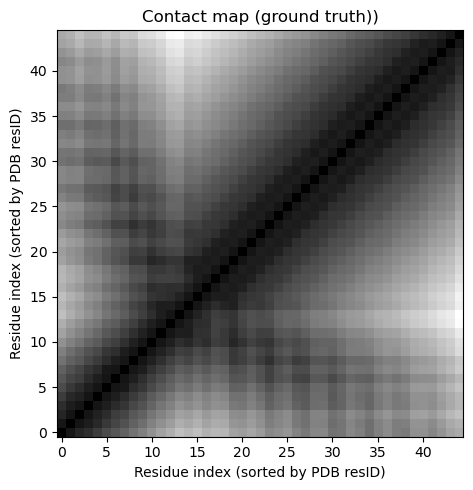

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
binder_id = "EGFR_2_279"
pdb_path = pdbs_Dict[binder_id]
cutoff = 8.0
min_seq_sep = 6.0

struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
# collect Cα coords
coords = [res["CA"].coord for res in struct[0]["A"] if res.id[0] == " " and "CA" in res]
X = np.asarray(coords) # [len, 3 coordinates of Cα]
N = len(X) # length of the sequence
D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N] # Cα–Cα pairwise distance matrix

T = (D <= cutoff) # True where the distance is smaller than cutoff
# remove self and short-range    
i,j = np.triu_indices(N, k=1)
short = (np.abs(i-j) < min_seq_sep)
T[i[short], j[short]] = False
T[j[short], i[short]] = False

plt.figure(figsize=(5,5))
plt.imshow(-D, origin="lower", interpolation="nearest", cmap="binary")
plt.title(f"Contact map (ground truth))")
plt.xlabel("Residue index (sorted by PDB resID)")
plt.ylabel("Residue index (sorted by PDB resID)")
plt.tight_layout()
plt.show()

pdb_str = pathlib.Path(pdb_path).read_text()

view = py3Dmol.view(width=600, height=500)
view.addModel(pdb_str, 'pdb')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view

In [15]:
pdbs_Dict["EGFR_2_279"]

'/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/input_pdbs/input_pdbs/jakublala_full_dibinder_45aa_pdb.pdb'

In [98]:
# sort by sequence length to reduce padding waste
L = model.num_layers
PatL = dict()

for i, start in enumerate(trange(0, len(data), 1, desc="Batches")):
    
    batch = data[start:start+batch_size]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch) # batch_converter adds special token PAD to make allt he sequences in the batch equal size
    batch_tokens = batch_tokens.to("cuda")
    
    lens_tokens = (batch_tokens != alphabet.padding_idx).sum(1) # claculated not padded token, include CLS/EOS (since only one sequence parsed, no padding was added)
    lens_res = (batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (batch_tokens != alphabet.eos_idx) # True for true residues, False for CLS/EOS
    lens = int(lens_res.sum(1)[0]) # residues only
    
    with torch.no_grad():
        out = model(batch_tokens, repr_layers=[L], return_contacts=True)
        
    contacts = out["contacts"][0].float().cpu()  # (B, T, C)
    D_pred = contacts[:lens, :lens]
    attentions = out["attentions"][0, -1, :, :, :].float().cpu() # [H, T', T']

    # image check
    # if i % 500 == 0:
    #     print(contacts.shape)
    #     plt.figure(figsize=(5,5))
    #     plt.imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
    #     plt.title(f"ESM-2 attention contacts {data_sorted[i][0]}")
    #     plt.xlabel("Token index")
    #     plt.ylabel("Token index")
    #     plt.tight_layout()
    #     plt.show()
    # else:
    #     pass

    binder_id = data[i][0]
    seq = data[i][1]
    N = len(seq)
    pdb_path = pdbs_Dict[binder_id]
    patLs_list = [] # list if p @ Ls starting one form the contact_map, head1, head2, ..., head20

    D_ground_all_float, T_ground_bool = true_contacts_ca(pdb_path)

    sorted_interactions = sorting_interactions(D_pred)
    
    p_at_L = precision_at_L(sorted_interactions, T_ground_bool, L=N)

    patLs_list.append(p_at_L)

    # Using heads (N=20)
    for idx, head in enumerate(attentions):
        # print(head.shape)
        attn_residue = head[1:-1, 1:-1] # head is [67,67], drop CLS/EOS -> [65,65]
        # print(attn_residue.shape)
        sorted_interactions = sorting_interactions(attn_residue)
        p_at_L = precision_at_L(sorted_interactions, T_ground_bool, L=N)
        # p_at_L5   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//5))
        # p_at_L2   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//2))
        # p_at_2L   = precision_at_L(sorted_interactions, T_ground_bool, L=min(2*N, len(sorted_interactions)))
        patLs_list.append(p_at_L)
    PatL[binder_id] = patLs_list
    # print(PatL)

    del out, contacts, batch_tokens
    torch.cuda.empty_cache()

Batches: 100%|██████████████████| 3532/3532 [36:39<00:00,  1.61it/s]


In [99]:
df_p_at_Ls = (pd.DataFrame.from_dict(PatL, orient="index").reset_index().rename(columns=lambda c: {0:"contact_map", **{i:f"head{i}" for i in range(1,21)}}.get(c, "binder_id")))

In [100]:
df_p_at_Ls

,binder_id,contact_map,head1,head2,head3,head4,head5,head6,head7,head8,...,head11,head12,head13,head14,head15,head16,head17,head18,head19,head20
0,VirB8_1,0.700,0.075,0.125,0.125,0.125,0.075,0.025,0.300,0.075,...,0.300,0.300,0.375,0.575,0.175,0.200,0.125,0.150,0.300,0.125
1,FGFR2_1,0.371,0.016,0.065,0.016,0.129,0.032,0.048,0.145,0.065,...,0.113,0.065,0.145,0.355,0.097,0.016,0.048,0.032,0.226,0.097
2,FGFR2_2,0.623,0.033,0.115,0.049,0.131,0.115,0.016,0.213,0.115,...,0.180,0.148,0.361,0.443,0.115,0.049,0.098,0.049,0.492,0.131
3,FGFR2_3,0.594,0.016,0.062,0.078,0.109,0.141,0.016,0.188,0.125,...,0.141,0.094,0.188,0.578,0.141,0.016,0.141,0.016,0.453,0.125
4,FGFR2_4,0.297,0.031,0.078,0.062,0.109,0.078,0.000,0.062,0.062,...,0.031,0.031,0.156,0.188,0.094,0.000,0.016,0.016,0.219,0.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,IL2Ra_62,0.473,0.018,0.000,0.036,0.036,0.073,0.018,0.055,0.055,...,0.073,0.091,0.109,0.418,0.000,0.018,0.036,0.000,0.327,0.145
3528,IL2Ra_63,0.429,0.000,0.018,0.089,0.018,0.071,0.000,0.071,0.161,...,0.054,0.054,0.161,0.321,0.071,0.000,0.000,0.000,0.304,0.036
3529,IL2Ra_64,0.536,0.054,0.071,0.054,0.125,0.125,0.018,0.161,0.196,...,0.196,0.089,0.232,0.339,0.107,0.036,0.161,0.107,0.464,0.018
3530,IL2Ra_65,0.351,0.000,0.105,0.053,0.175,0.105,0.018,0.053,0.053,...,0.140,0.123,0.140,0.333,0.000,0.018,0.070,0.018,0.316,0.140


In [102]:
df_p_at_Ls.to_csv("../data/meta_analysis/binder_p_at_Ls_thres8_6.csv", index=False)

### Pseudo-log-likelyhood calculation

In [8]:
# def __init__(self, model_name: str = 'esm2_t33_650M_UR50D'):
#     """
#     Initializes the model, alphabet, and batch converter.

#     Args:
#         model_name (str): The name of the pre-trained ESM-2 model to load.
#     """
#     self.mask_str_token = "<mask>"
#     self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_name)
#     self.batch_converter = self.alphabet.get_batch_converter()
#     self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     self.model = self.model.to(self.device)
#     self.model.eval()  # Disable dropout for deterministic results

#     print(f"ESM-2 model '{model_name}' loaded on {self.device}.")

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def _generate_masked_sequences(sequence: str, mask_length: list):
    """
    Generates sequences with a sliding window of masks of length N.

    Args:
        sequence (str): The input protein sequence.
        mask_length (int): The number of adjacent tokens to mask (N).

    Yields:
        A tuple containing the masked sequence string, the start index of the
        mask, and the end index of the mask.
    """
    np.random.seed(0)
    seq_indexes = np.arange(0,len(sequence))
    np.random.shuffle(seq_indexes)
    # print(seq_indexes)
    batched_seq_indexes = list(batch(seq_indexes,n=1))
    # print(batched_seq_indexes)
    all_sequences = []
    for masked_index in batched_seq_indexes: # if mask_length=1, then only 1 index
        seq_copy = list(sequence).copy() # make sequence into list
        for index in masked_index:
            seq_copy[index] = "<mask>"
            
        all_sequences.append((masked_index,"".join(seq_copy)))
    
    return all_sequences

seq = "LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK"

all_sequences = _generate_masked_sequences(sequence = seq, mask_length = 1)

In [9]:
all_sequences[:5]

[(array([22]), 'LDFIVFAGPEKAIKFYKEMAKR<mask>LEVKIWIDGDWAVVQVK'),
 (array([20]), 'LDFIVFAGPEKAIKFYKEMA<mask>RNLEVKIWIDGDWAVVQVK'),
 (array([25]), 'LDFIVFAGPEKAIKFYKEMAKRNLE<mask>KIWIDGDWAVVQVK'),
 (array([4]), 'LDFI<mask>FAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK'),
 (array([10]), 'LDFIVFAGPE<mask>AIKFYKEMAKRNLEVKIWIDGDWAVVQVK')]

In [10]:
print(all_sequences[0][0]) # masked amino acid
print(all_sequences[0][1]) # seqeunced with mask

[22]
LDFIVFAGPEKAIKFYKEMAKR<mask>LEVKIWIDGDWAVVQVK


In [11]:
print(len(alphabet))              # -> 33 (vocab size V)
print(alphabet.all_toks)          # list of token strings
print(alphabet.get_idx('A'))      # int id for 'A'
print(alphabet.get_tok(0))        # token string for id 0

33
['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>']
5
<cls>


In [12]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
model = model.to("cuda")
batch_converter = alphabet.get_batch_converter()

Using cache found in /work3/s232958/torch/hub/facebookresearch_esm_main


In [13]:
data[1]

('FGFR2_1', 'SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEAKKLVRSLQEYLESILS')

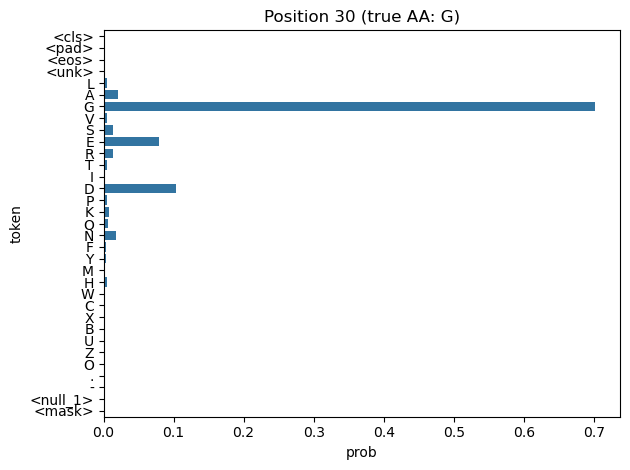

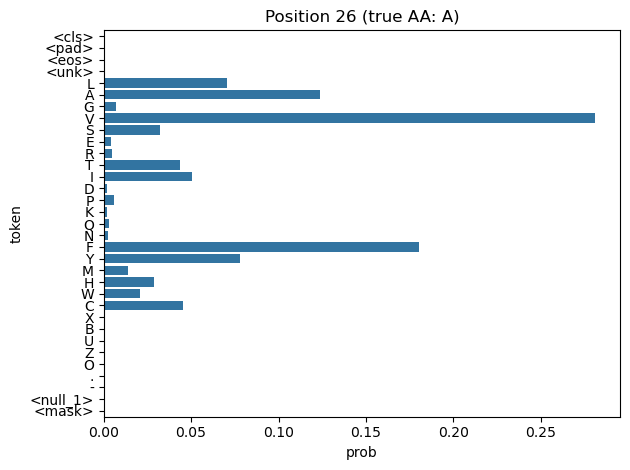

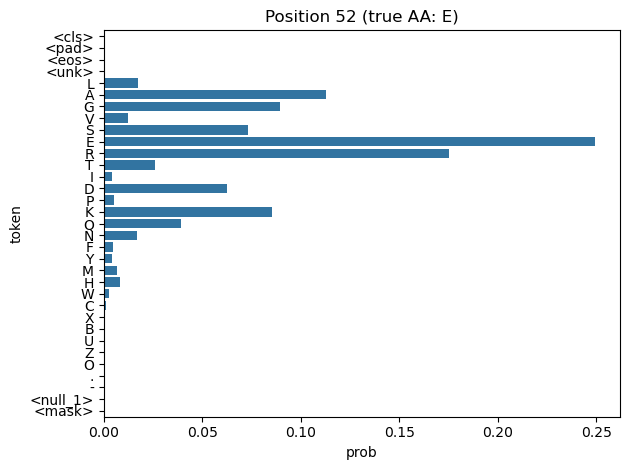

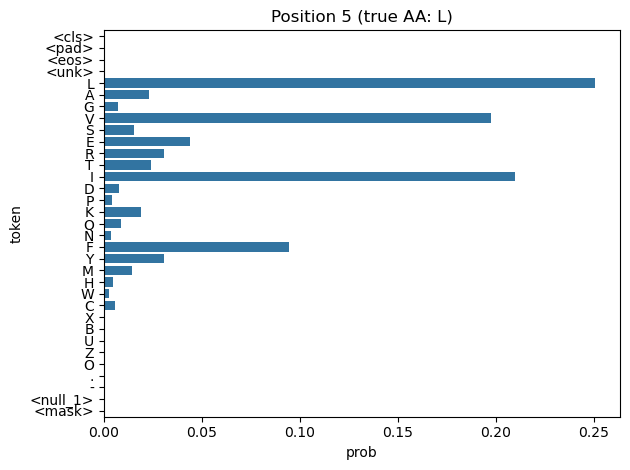

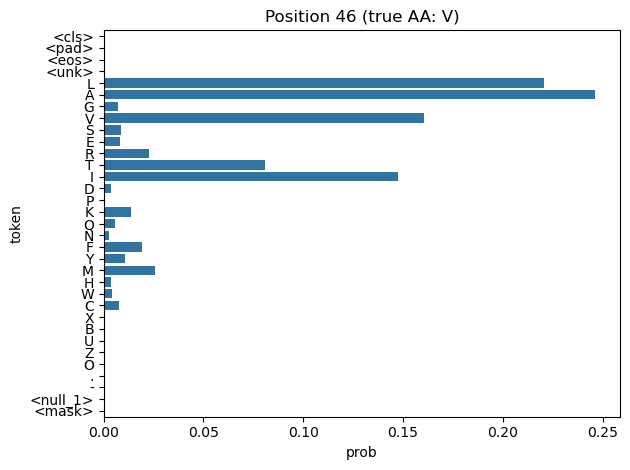

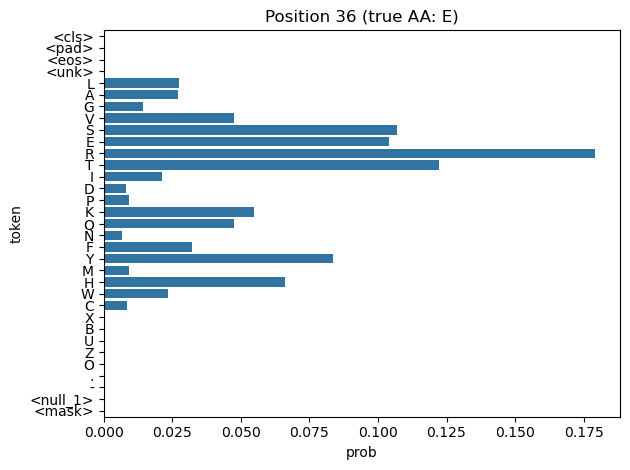

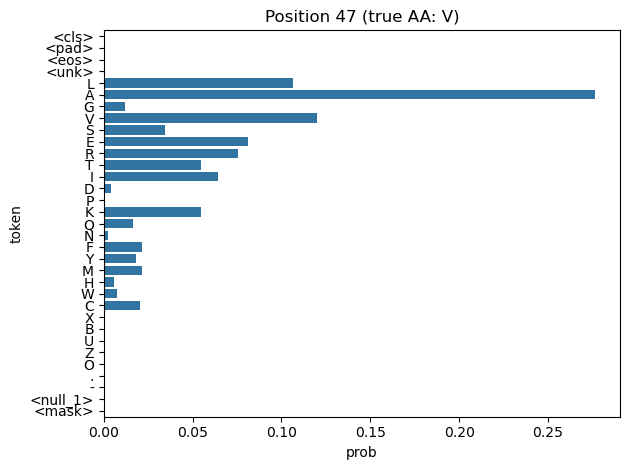

Average log-likelihood: -2.084777355194092
Pseudo-perplexity: 8.042800903320312


/work3/s232958/tmp/ipykernel_2626609/1704511087.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pll = torch.exp(-torch.tensor(avg_log_likelihood)).item() # the lower the better


8.042800903320312

In [41]:
@torch.no_grad()
def calculate_pll_score(sequence: str, mask_length: int = 1) -> float:
    """
    Calculates a score based on the model's ability to predict residues
    within a sliding window of N masked tokens.

    When mask_length=1, this is equivalent to standard pseudo-log-likelihood (pLL).

    Args:
        sequence (str): The input protein sequence.
        mask_length (int): The length of the mask stretch (N).
        batch_size (int): The number of masked sequences to process in each batch.

    Returns:
        float: The calculated pseudo-perplexity-like score.
    """
    if not sequence or not isinstance(sequence, str):
        raise ValueError("Input sequence must be a non-empty string.")

    # Set seed for suffling
    np.random.seed(0)
            
    # 1. Generate all sequences with sliding window masks
    masked_data = _generate_masked_sequences(sequence, mask_length)

    # ESM-2 input
    ESM_input = [(i, masked_seq[1]) for i, masked_seq in enumerate(masked_data)] #masked_seq[1] - masked sequence
 
    # 2. Convert to batches
    batch_labels, batch_strs, batch_tokens = batch_converter(ESM_input)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to("cuda")
    
    # 3. Pass through ESM-2
    out = model(batch_tokens, repr_layers=[33], return_contacts=False)
    logits = out["logits"] # e.g. logits.shape (40, 42, 33)
    """
    B=40: you created 40 masked variants (one per masked position).
    T=42: your 40-residue sequence plus [CLS] at start and [EOS] at end.
    V=33: the model’s vocabulary size (all tokens it can predict).
        - 20 standard amino acids
        - special/ambiguous tokens and special symbols used by the model - [CLS], [EOS], [PAD], [MASK];
        - ambiguous amino acids like X, B, Z, possibly U, O.
    """
    logit_prob = torch.nn.functional.log_softmax(logits, dim=-1) # dim=-1 - so that last dimension (size 33) would be used 
    tok_labels = list(alphabet.all_toks)  # ['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>']

    # 4. Calcualte PLL
    log_likelihood = 0
    for i, (masked_index, _) in enumerate(masked_data):
        
        for j in masked_index: # if more than one mask per sequence
            
            # print(alphabet.all_toks)
            # print(torch.sigmoid(logit_prob[i, j+1]))
            # print(alphabet.get_idx(sequence[j]))

            if i % 10 == 0:
                # probabilities over the 33 tokens at position j (account for CLS shift)
                probs = logit_prob[i, j+1, :].exp().detach().cpu().numpy()  # i - masked seqeunce, j - position of residue (+1 account for CLS shift)
                
                # print(f"True amino acid: {sequence[j]}")
                # for i, p in enumerate(probs):
                #     print(tok_labels[i], round(p,2)) 

                df_plot = pd.DataFrame({"token": tok_labels, "prob": probs})
                ax = sns.barplot(data=df_plot, x="prob", y="token", orient="h")
                ax.set_title(f"Position {j} (true AA: {sequence[j]})")
                plt.tight_layout()
                plt.show()
            
            log_likelihood += logit_prob[i, j+1, alphabet.get_idx(sequence[j])]
            """
            j+1   shifts for the leading [CLS]
            alphabet.get_idx(sequence[j])  int id for true amino acid masked
            """
    
    # Calculate the average log likelihood per token
    avg_log_likelihood = log_likelihood / len(sequence) # or / logit_prob.shape[0] # the higher the better
    print(f"Average log-likelihood: {avg_log_likelihood.item()}")

    # Compute and return the pseudo-perplexity
    pll = torch.exp(-torch.tensor(avg_log_likelihood)).item() # the lower the better
    print(f"Pseudo-perplexity: {pll}")
    return pll

i = random.randint(0, len(data))
calculate_pll_score(sequence = data[i][1], mask_length = 1)

- log_likelihood - you take predicted probability for the true amino acid; you sum over all the masked positions
- avg_log_likelihood - you devide the log_likelihood by the number of masked sequences (len(sequence) or logit_prob.shape[0])
- pll - exponent(-avg_log_likelihood)

Thus:
`avg_log_likelihood` - *higher better*, while `pll` - *lower better*

In [35]:
np.exp(-(-2.4805))

11.94723654296489

**Note:** all PLL computed for all the sequences in the meta-analysis dataset are stored in:
`DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/all_inputs_updated_ny2_w_sequences_w_pll.csv`